## EXTRACTION

In [ ]:
"""
import fnmatch
import os
import zipfile

def extract_files(zip_file, out_dir, delete_zip=False):
    # create audio directory
    audio_dir = os.path.join(out_dir, 'audio')
    if not os.path.exists(audio_dir):
        os.makedirs(audio_dir)

    # create transcripts directory
    transcripts_dir = os.path.join(out_dir, 'transcripts')
    if not os.path.exists(audio_dir):
        os.makedirs(transcripts_dir)

    formant_dir = os.path.join(out_dir, 'formant')
    if not os.path.exists(audio_dir):
        os.makedirs(formant_dir)

    zip_ref = zipfile.ZipFile(zip_file)
    for f in zip_ref.namelist():  # iterate through files in zip file
        if f.endswith('.wav'):
            zip_ref.extract(f, audio_dir)
        elif fnmatch.fnmatch(f, '*TRANSCRIPT.csv'):
            zip_ref.extract(f, transcripts_dir)
        elif fnmatch.fnmatch(f, '*FORMANT.csv'):
            zip_ref.extract(f, formant_dir)
    
    zip_ref.close()

    if delete_zip:
        os.remove(zip_file)

if __name__ == '__main__':
    # directory containing DIAC-WOZ zip files
    dir_name = 'D:/dataset/fyp/new_woz/new_daicWoz'

    # directory where audio and transcripts folders will be created
    out_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_extracted'
    # delete zip file after file wav and csv extraction
    delete_zip = False

    # iterate through zip files in dir_name and extracts wav and transcripts
    for file in os.listdir(dir_name):
        if file.endswith('.zip'):
            zip_file = os.path.join(dir_name, file)
            extract_files(zip_file, out_dir, delete_zip=delete_zip)
            

## SEGMENTATION

In [ ]:
"""
import os
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
import scipy.io.wavfile as wavfile
import wave
import soundfile as sf
import librosa

def remove_silence(filename, out_dir, smoothing=1.0, weight=0.3, plot=False):
    partic_id = 'P' + filename.split('/')[-1].split('_')[0]  # PXXX
    if is_segmentable(partic_id):
        # create participant directory for segmented wav files
        participant_dir = os.path.join(out_dir, partic_id)
        if not os.path.exists(participant_dir):
            os.makedirs(participant_dir)

        os.chdir(participant_dir)

        [Fs, x] = aIO.read_audio_file(filename)
        segments = aS.silence_removal(x, Fs, 0.020, 0.020,
                                     smooth_window=smoothing,
                                     weight=weight,
                                     plot=plot)

        for s in segments:
            seg_name = "{:s}_{:.2f}-{:.2f}.wav".format(partic_id, s[0], s[1])
            wavfile.write(seg_name, Fs, x[int(Fs * s[0]):int(Fs * s[1])])

        # concatenate segmented wave files within participant directory
        concatenate_segments(participant_dir, partic_id)


def is_segmentable(partic_id):
    troubled = set(['P300', 'P305', 'P306', 'P308', 'P315', 'P316', 'P343',
                    'P354', 'P362', 'P375', 'P378', 'P381', 'P382', 'P385',
                    'P387', 'P388', 'P390', 'P392', 'P393', 'P395', 'P408',
                    'P413', 'P421', 'P438', 'P473', 'P476', 'P479', 'P490',
                    'P492'])
    return partic_id not in troubled


def concatenate_segments(participant_dir, partic_id, remove_segment=True):
    infiles = os.listdir(participant_dir)  # list of wav files in directory
    outfile = '{}_no_silence.wav'.format(partic_id)

    data = []
    for infile in infiles:
        w = wave.open(infile, 'rb')
        data.append([w.getparams(), w.readframes(w.getnframes())])
        w.close()
        if remove_segment:
            os.remove(infile)

    output = wave.open(outfile, 'wb')
    # details of the files must be the same (channel, frame rates, etc.)
    output.setparams(data[0][0])

    # write each segment to output
    for idx in range(len(data)):
        output.writeframes(data[idx][1])
    output.close()

if __name__ == '__main__':
    # directory containing raw wav files
    dir_name = 'D:/dataset/fyp/new_woz/new_daicWoz_extracted/audio/'

    # directory where a participant folder will be created containing their
    # segmented wav file
    out_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_interim/'

    # iterate through wav files in dir_name and create a segmented wav_file
    for file in os.listdir(dir_name):
        if file.endswith('.wav'):
            filename = os.path.join(dir_name, file)
            remove_silence(filename, out_dir)


In [ ]:
from glob import glob

audio_files_train = glob ('D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/train/*.wav')
audio_files_test = glob ('D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/test/*.wav')

## CREATE SPECTROGRAM

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio data and create spectrograms
def create_spectrogram(audio_path, output_dir, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
    audio_data, _ = librosa.load(audio_path, sr=sample_rate, duration=duration)
    
    plt.figure(figsize=(10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    
    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(audio_path))[0]
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, f'{file_name}_spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return mel_spectrogram, image_path

audio_path = 'D:/dataset/fyp/new_woz/new_daicWoz_interim/audio.wav'
output_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_interim/spectogram'

create_spectrogram(audio_path, output_dir)


## LABELLING

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time

# Record the start time
start_time = time.time()

# Define the directory where your spectrogram images are stored
spectrogram_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/train/greyscale'

# Create empty lists to store spectrograms and labels
spectrograms = []
labels = []

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
  # Load the image (you may need to install PIL or another image library)
  image = plt.imread(image_path)
    
  # Perform inverse of the preprocessing steps in create_spectrogram
  mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
  audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

  return audio_data

# Load spectrograms and labels
for root, dirs, files in os.walk(spectrogram_dir):
  for file in files:
    if file.endswith("_spectrogram.png"):
      image_path = os.path.join(root, file)
      label = 0 if "normal" in root else 1  # Adjust labeling based on your folder structure
      spectrogram = load_spectrogram(image_path)  # Load the spectrogram image

      spectrograms.append(spectrogram)
      labels.append(label)

# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time

# Print the total time taken
print(f"Total loading time: {total_time} seconds")

C:\Python311\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


In [ ]:
# Convert lists to NumPy arrays
spectrograms = np.array(spectrograms)
labels = np.array(labels)

# Split the dataset into training and testing sets (optional)
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=None, random_state=42)

# Cast labels to float32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# One-hot encode labels
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)

# Verify the shape of the arrays
print("Spectrograms shape:", spectrograms.shape)
print("Labels shape:", labels.shape)

In [ ]:
print(labels)

## GREYSCALING

In [19]:
from PIL import Image
import os

def png_to_grayscale(input_path, output_path):
    # Open the image
    image = Image.open(input_path)

    # Convert the image to grayscale
    grayscale_image = image.convert("L")

    # Save the grayscale image
    grayscale_image.save(output_path)

def process_directory(input_dir, output_dir):
    # List all PNG files in the input directory
    for file in os.listdir(input_dir):
        if file.endswith(".png"):
            input_path = os.path.join(input_dir, file)

            # Create a corresponding output path
            output_path = os.path.join(output_dir, file)

            # Convert the image to grayscale
            png_to_grayscale(input_path, output_path)

# Example usage:
input_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/train/spectogram/depressed'
output_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/greyscale/train/depressed'
process_directory(input_dir, output_dir)


## MODEL ARCHITECTURE

In [8]:
import tensorflow as  tf
tf. __version__ 

'2.14.0'

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical

input_shape = (spectrograms.shape[1], 1)

model = Sequential()

model.add(Conv1D(32, 3, padding='valid', strides=1, input_shape=input_shape, activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=3))
model.add(Conv1D(32, 1, padding='valid', strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(2, activation='sigmoid'))  # Assuming 2 classes for binary classification encoded
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.F1Score(), 
                       tf.keras.metrics.TrueNegatives(), 
                       tf.keras.metrics.TruePositives(), 
                       tf.keras.metrics.FalseNegatives(), 
                       tf.keras.metrics.FalsePositives()])

In [ ]:
import time

# Record the start time
start_time = time.time()

# Fit the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time

# Print the total time taken
print(f"Total training time: {total_time} seconds")

## SAVING MODEL

In [ ]:
print('Saving model locally...')
model.save('CNN_DepressionDetectorRedo.keras')
print('Done saving')

## Adam

In [15]:
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model2.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 7s 7s/step
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


In [16]:
predictions = model2.predict(spectrograms)
print(predictions)

1/1 [==============================] - 3s 3s/step
[[0.00816995]
 [0.00744675]
 [0.00672348]
 [0.00752326]
 [0.00770855]
 [0.00639508]
 [0.00653487]
 [0.00789941]
 [0.00626591]
 [0.0083507 ]
 [0.00596069]
 [0.00520304]
 [0.00729406]
 [0.00854894]
 [0.00452138]
 [0.00754287]
 [0.00536755]
 [0.00808171]
 [0.00594846]
 [0.00667917]
 [0.00457808]
 [0.00897381]
 [0.00591129]
 [0.00715632]
 [0.00632433]
 [0.00565728]
 [0.00778803]
 [0.00794096]
 [0.00617617]
 [0.00655556]]


In [17]:
predictions = model2.predict(spectrograms)
predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 3s 3s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.30      1.00      0.46         9
           1       1.00      0.00      0.00        21

    accuracy                           0.30        30
   macro avg       0.65      0.50      0.23        30
weighted avg       0.79      0.30      0.14        30

Accuracy Score: 0.3


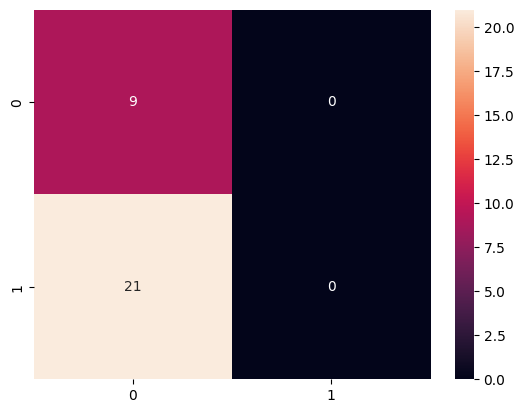

In [18]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## INFERENCE

In [1]:
import tensorflow as tf

print('Loading model')
model1 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_no.keras')
model2 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_adam.keras')
model3 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_FTRL.keras')
model4 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_RMSprop.keras')
print('Model loaded')

Loading model
Model loaded


### Create Spectrogram

In [ ]:
"""
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio data and create spectrograms
def create_spectrogram(audio_path, output_dir, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
    audio_data, _ = librosa.load(audio_path, sr=sample_rate, duration=duration)
    
    plt.figure(figsize=(10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    
    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(audio_path))[0]
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, f'{file_name}_spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return mel_spectrogram, image_path

# Directory containing audio files
audio_directory = 'D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/inference/audio'
output_directory = 'D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/inference/spectrogram'

# Iterate over audio files in the directory
for audio_file in os.listdir(audio_directory):
    if audio_file.endswith('.wav'):  # Adjust the condition based on your file extension
        audio_path = os.path.join(audio_directory, audio_file)
        create_spectrogram(audio_path, output_directory)


In [6]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define the directory where your spectrogram images are stored
spectrogram_dir = 'D:/dataset/fyp/new_woz/new_daicWoz_interim_labelled/inference/spectrogram'

# Create empty lists to store spectrograms 
spectrograms = []

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
  # Load the image (you may need to install PIL or another image library)
  image = plt.imread(image_path)

  # Convert the image to grayscale if needed
  if len(image.shape) == 3:
    image = image.mean(axis=-1)

  # Perform inverse of the preprocessing steps in create_spectrogram
  mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
  audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

  return audio_data

# Load spectrograms and labels
for root, dirs, files in os.walk(spectrogram_dir):
  for file in files:
    if file.endswith("_spectrogram.png"):
      image_path = os.path.join(root, file)
      spectrogram = load_spectrogram(image_path)  # Load the spectrogram image
      spectrograms.append(spectrogram)

# Prepare the spectrogram
spectrograms = np.array(spectrograms)

C:\Python311\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


### No Optimiser

In [9]:
import numpy as np

def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model1.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 48s 48s/step
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


In [11]:
predictions = model1.predict(spectrograms)
print(predictions)

1/1 [==============================] - 3s 3s/step
[[0.00978812]
 [0.00978055]
 [0.00929826]
 [0.009499  ]
 [0.00943692]
 [0.00940845]
 [0.00936223]
 [0.00922634]
 [0.00935709]
 [0.01009066]
 [0.00934237]
 [0.00948166]
 [0.00985587]
 [0.01077146]
 [0.01026493]
 [0.009688  ]
 [0.00955379]
 [0.00969015]
 [0.00994733]
 [0.00955622]
 [0.00929312]
 [0.00989296]
 [0.01042378]
 [0.00983182]
 [0.00918934]
 [0.00890831]
 [0.00944026]
 [0.00974372]
 [0.00937189]
 [0.00968419]]


In [12]:
predictions = model1.predict(spectrograms)
predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 3s 3s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.30      1.00      0.46         9
           1       1.00      0.00      0.00        21

    accuracy                           0.30        30
   macro avg       0.65      0.50      0.23        30
weighted avg       0.79      0.30      0.14        30

Accuracy Score: 0.3


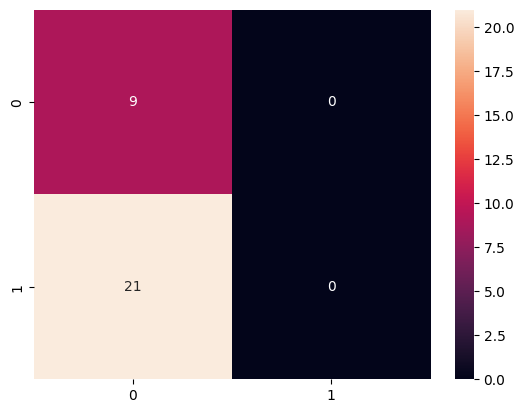

In [33]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## FTRL

In [19]:
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model3.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 33s 33s/step
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


In [20]:
predictions = model3.predict(spectrograms)
print(predictions)

1/1 [==============================] - 8s 8s/step
[[0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]
 [0.49793375]]


In [21]:
predictions = model3.predict(spectrograms)
predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 3s 3s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.30      1.00      0.46         9
           1       1.00      0.00      0.00        21

    accuracy                           0.30        30
   macro avg       0.65      0.50      0.23        30
weighted avg       0.79      0.30      0.14        30

Accuracy Score: 0.3


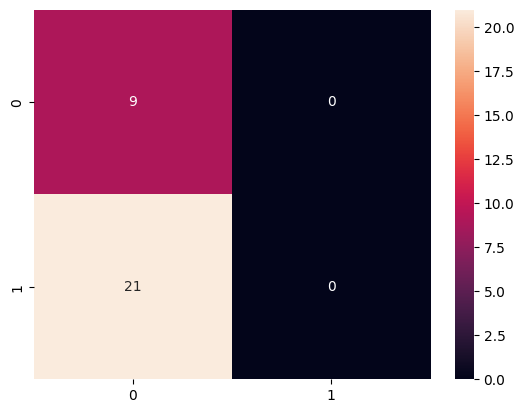

In [22]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## RMSProp

In [23]:
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model4.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 44s 44s/step
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


In [24]:
predictions = model4.predict(spectrograms)
print(predictions)

1/1 [==============================] - 3s 3s/step
[[0.11139734]
 [0.11400294]
 [0.1101255 ]
 [0.11197493]
 [0.11168801]
 [0.11082914]
 [0.11105518]
 [0.11043775]
 [0.11078589]
 [0.11251464]
 [0.11169104]
 [0.11246064]
 [0.11447491]
 [0.11584726]
 [0.11405863]
 [0.11297768]
 [0.11128416]
 [0.11158766]
 [0.11380549]
 [0.11259173]
 [0.11170523]
 [0.11345003]
 [0.11399099]
 [0.113333  ]
 [0.10981832]
 [0.10881356]
 [0.11211088]
 [0.11132713]
 [0.11098541]
 [0.11206979]]


In [25]:
predictions = model4.predict(spectrograms)
predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 2s 2s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.30      1.00      0.46         9
           1       1.00      0.00      0.00        21

    accuracy                           0.30        30
   macro avg       0.65      0.50      0.23        30
weighted avg       0.79      0.30      0.14        30

Accuracy Score: 0.3


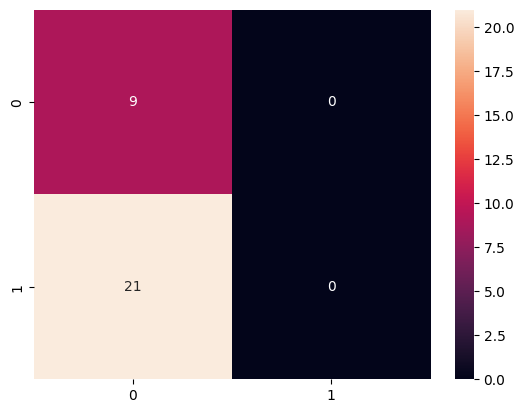

In [26]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## Adam E10

In [7]:
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model5.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 36s 36s/step
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed
depressed


In [8]:
predictions = model5.predict(spectrograms)
print(predictions)

1/1 [==============================] - 9s 9s/step
[[0.9616876  0.0612007 ]
 [0.9634312  0.0573743 ]
 [0.96468467 0.05641032]
 [0.9635481  0.05820911]
 [0.9622026  0.06013614]
 [0.9640702  0.05847508]
 [0.9666207  0.05200748]
 [0.9641763  0.05974013]
 [0.96585613 0.05369168]
 [0.96313167 0.05922566]
 [0.9670265  0.05270633]
 [0.9664288  0.05451998]
 [0.96482325 0.05626824]
 [0.9570282  0.06805485]
 [0.9620308  0.05910489]
 [0.965719   0.05541666]
 [0.9667497  0.0529258 ]
 [0.96521115 0.05597352]
 [0.96219087 0.05947104]
 [0.9623748  0.05789335]
 [0.9657355  0.05455944]
 [0.96270084 0.0600196 ]
 [0.96287906 0.06013657]
 [0.9642712  0.05738085]
 [0.9661417  0.05402422]
 [0.96315336 0.05979992]
 [0.9629739  0.05992764]
 [0.95995843 0.06401414]
 [0.9670857  0.05259157]
 [0.96467274 0.05565492]]


In [20]:
predictions = model5.predict(spectrograms)
#predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
predictions = [0 if average_prediction[0] < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 10s 10s/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


              precision    recall  f1-score   support

           0       1.00      0.00      0.00         9
           1       0.70      1.00      0.82        21

    accuracy                           0.70        30
   macro avg       0.85      0.50      0.41        30
weighted avg       0.79      0.70      0.58        30

Accuracy Score: 0.7


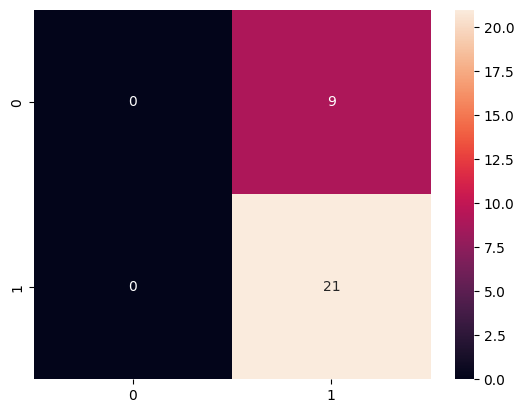

In [21]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## Adam E50

In [10]:
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model6.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 26s 26s/step
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


In [11]:
predictions = model6.predict(spectrograms)
print(predictions)

1/1 [==============================] - 4s 4s/step
[[6.1466790e-07]
 [6.4117182e-07]
 [7.6339006e-07]
 [6.3803049e-07]
 [3.5969848e-07]
 [6.1889006e-07]
 [7.0046002e-07]
 [1.0107113e-06]
 [6.6701841e-07]
 [7.9818386e-07]
 [3.9735789e-07]
 [6.2741969e-07]
 [1.5885780e-06]
 [1.2040024e-06]
 [8.6206609e-07]
 [6.4509840e-07]
 [4.6995197e-07]
 [6.3765634e-07]
 [6.5728875e-07]
 [9.0232754e-07]
 [6.6417465e-07]
 [8.3018415e-07]
 [4.9158433e-07]
 [8.0788766e-07]
 [7.3953134e-07]
 [4.0885121e-07]
 [4.5305441e-07]
 [6.4923478e-07]
 [5.6789452e-07]
 [7.5601105e-07]]


In [12]:
predictions = model6.predict(spectrograms)
predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 2s 2s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.30      1.00      0.46         9
           1       1.00      0.00      0.00        21

    accuracy                           0.30        30
   macro avg       0.65      0.50      0.23        30
weighted avg       0.79      0.30      0.14        30

Accuracy Score: 0.3


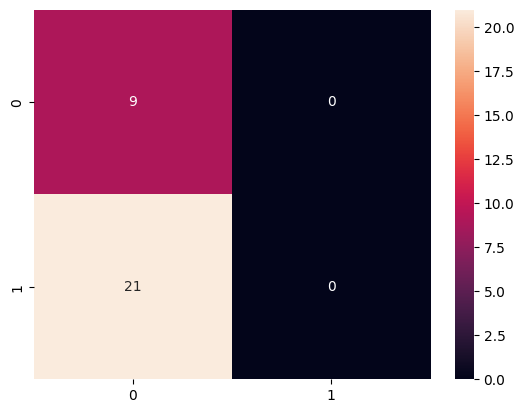

In [13]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## Adam E100

In [14]:
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "depressed" if average_prediction > threshold else "normal"

predictions = model7.predict(spectrograms)

# Make binary predictions for each spectrogram and print them to the console.
for prediction in predictions:
    binary_prediction = convert_predictions_to_binary(prediction)
    print(binary_prediction)

1/1 [==============================] - 35s 35s/step
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


In [15]:
predictions = model7.predict(spectrograms)
print(predictions)

1/1 [==============================] - 3s 3s/step
[[2.5922968e-06]
 [2.5963568e-06]
 [7.7103614e-06]
 [5.7300517e-06]
 [3.4882969e-06]
 [1.8085190e-06]
 [3.1022255e-06]
 [2.5235677e-06]
 [2.4140022e-06]
 [1.8286282e-06]
 [3.9989000e-06]
 [3.6559261e-06]
 [3.2075818e-06]
 [5.6314761e-06]
 [5.1703482e-06]
 [4.2056886e-06]
 [2.1796450e-06]
 [1.8123916e-06]
 [2.6417495e-06]
 [3.8728012e-06]
 [2.6529945e-06]
 [5.6754652e-06]
 [2.5366990e-06]
 [1.9782553e-06]
 [2.2847621e-06]
 [2.1604030e-06]
 [2.7254200e-06]
 [2.8935654e-06]
 [1.5987243e-06]
 [3.9822316e-06]]


In [16]:
predictions = model7.predict(spectrograms)
predictions = [0 if average_prediction < 0.5 else 1 for average_prediction in predictions]
print(predictions)

1/1 [==============================] - 5s 5s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.30      1.00      0.46         9
           1       1.00      0.00      0.00        21

    accuracy                           0.30        30
   macro avg       0.65      0.50      0.23        30
weighted avg       0.79      0.30      0.14        30

Accuracy Score: 0.3


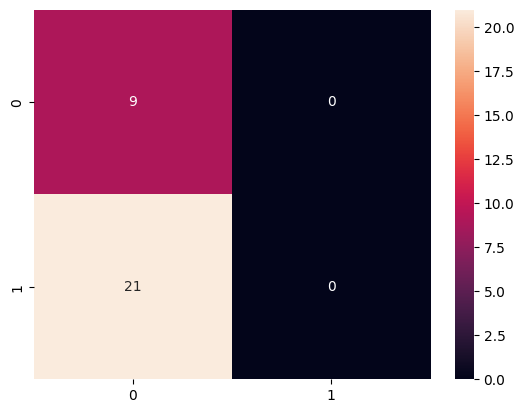

In [17]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

hindsight = ["depressed", "depressed", "depressed", "depressed", "depressed", "depressed",
             "depressed", "depressed", "depressed", 
             
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", 
             "normal", "normal", "normal"]

hindsight = [0 if hindsight == "depressed"  else 1 for hindsight in hindsight]

print(classification_report(hindsight, predictions, zero_division = 1))
print("Accuracy Score:", accuracy_score(hindsight, predictions))

cm = confusion_matrix(hindsight, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

## PYTHON UI

In [1]:
import tensorflow as tf

print('Loading model')
#model1 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_no.keras')
#model2 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_adam.keras')
#model3 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_FTRL.keras')
#model4 = tf.keras.models.load_model('CNN_DepressionDetectorRetry_RMSprop.keras')
model = tf.keras.models.load_model('CNN_DepressionDetectorRedo.keras')
#model6 = tf.keras.models.load_model('CNN_DepressionDetectorRestart_Adam_E50.keras')
#model7 = tf.keras.models.load_model('CNN_DepressionDetectorRestart_Adam_E100.keras')
print('Model loaded')

Loading model
Model loaded


### Testing

In [7]:
import os
import keyboard
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from tkinter import Tk, Button, Label

# Load audio data and create spectrograms
def create_spectrogram(audio_data, output_dir, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
    plt.figure(figsize=(10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, 'spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return mel_spectrogram, image_path

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, hop_length=512, n_mels=128):
    # Load the image (you may need to install PIL or another image library)
    image = plt.imread(image_path)

    # Convert the image to grayscale if needed
    if len(image.shape) == 3:
        image = image.mean(axis=-1)

    # Perform inverse of the preprocessing steps in create_spectrogram
    mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
    audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

    return audio_data

# Convert predictions to binary
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.6
    return "Depressed" if average_prediction > threshold else "Normal"

# Function to start recording from the user's microphone
def record_audio():
    duration = 5  # seconds
    sample_rate = 22050

    # Record audio from the microphone
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()

    # Create a directory to store spectrogram images
    output_dir = 'spectrogram'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a spectrogram from the recorded audio
    mel_spectrogram, image_path = create_spectrogram(audio_data.flatten(), output_dir)

    # Load the spectrogram and make predictions
    spectrogram = load_spectrogram(image_path)
    predictions = model.predict(np.expand_dims(spectrogram, axis=0))

    # Make binary predictions and display the result
    result_label.config(text = convert_predictions_to_binary(predictions))

# GUI
root = Tk()
root.title("Depression Detection")

# Title Label
title_label = Label(root, text="Please Read the Following Paragraph", font=("Helvetica", 16))
title_label.pack()

# Paragraph Label
paragraph_label = Label(root, text="""
                This sentence has five words. Here are five more words. 
                Five-word sentences are fine. But several together become monotonous. Listen to what is happening. 
                The writing is getting boring. The sound of it drones. It’s like a stuck record. The ear demands some variety. 
                Now listen. I vary the sentence length, and I create music. Music. The writing sings. It has a pleasant rhythm, a lilt, a harmony. 
                I use short sentences. And I use sentences of medium length. And sometimes, when I am certain the reader is rested, 
                I will engage him with a sentence of considerable length, 
                a sentence that burns with energy and builds with all the impetus of a crescendo, 
                the roll of the drums, the crash of the cymbals–sounds that say listen to this, it is important. – Gary Provost
                """)
paragraph_label.pack()

record_button = Button(root, text="Record", command=record_audio)
record_button.pack()

result_label = Label(root, text="Your Condition:" + " ")
result_label.pack()

root.mainloop()

### Real

#### Paragraph 1

In [5]:
import os
import keyboard
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from tkinter import Tk, Button, Label
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Global variable for audio data
audio_data = None

# Load audio data and create spectrograms
def create_spectrogram(audio_data, output_dir, sample_rate = 22050, duration = 4, hop_length = 512, n_mels = 128):
    plt.figure(figsize = (10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y = audio_data, sr = sample_rate, hop_length = hop_length, n_mels = n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref = np.max), y_axis = 'mel', x_axis = 'time')
    plt.colorbar(format = '%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, 'spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches = 'tight', pad_inches = 0)
    plt.close()

    return mel_spectrogram, image_path

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, hop_length=512, n_mels=128):
    # Load the image (you may need to install PIL or another image library)
    image = plt.imread(image_path)

    # Convert the image to grayscale if needed
    if len(image.shape) == 3:
        image = image.mean(axis = -1)

    # Perform inverse of the preprocessing steps in create_spectrogram
    mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
    audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

    return audio_data

# Convert predictions to binary
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "Depressed" if average_prediction > threshold else "Normal"

def convert_predictions_to_stage(predictions):
    average_prediction = np.mean(predictions)

    if average_prediction < 0.5:
        return "Normal"
    elif 0.5 <= average_prediction <= 0.7:
        return "Early Stage"
    elif 0.8 <= average_prediction <= 1.0:
        return "Chronic Stage"
    else:
        return "Invalid Prediction"

# Function to start recording from the user's microphone
def record_audio():
    global audio_data  # Use the global variable
    duration = 60  # seconds
    sample_rate = 22050

    # Record audio from the microphone
    audio_data = sd.rec(int(sample_rate * duration), samplerate = sample_rate, channels = 1, dtype = np.float32)
    sd.wait()

# Function to process recorded audio
def process_audio():
    global audio_data  # Use the global variable
    global result_text

    if audio_data is not None:
        
        # Create a directory to store audio recordings
        output_dir = 'recording'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the recorded audio as a WAV file
        audio_file_path = os.path.join(output_dir, 'recorded_audio.wav')
        sf.write(audio_file_path, audio_data.flatten(), samplerate = 22050)
        
        # Create a directory to store spectrogram images
        output_dir = 'spectrogram'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Create a spectrogram from the recorded audio
        mel_spectrogram, image_path = create_spectrogram(audio_data.flatten(), output_dir)

        # Load the spectrogram and make predictions
        spectrogram = load_spectrogram(image_path)
        predictions = model.predict(np.expand_dims(spectrogram, axis=0))

        # Make binary predictions
        result_text = convert_predictions_to_binary(predictions)
        result_label.config(text = "Your Condition: " + result_text)

        phase_text = convert_predictions_to_stage(predictions)
        phase_label.config(text = "Ibnu Sina Stage: " + phase_text)
        
        # Calculate performance metrics
        accuracy = accuracy_score(np.round(predictions), np.round(predictions))  # No ground truth labels, so using predictions as ground truth
        precision = precision_score(np.round(predictions), np.round(predictions))
        recall = recall_score(np.round(predictions), np.round(predictions))
        f1 = f1_score(np.round(predictions), np.round(predictions))

        # Display performance metrics
        accuracy_label.config(text = "Accuracy: {:.2f}".format(accuracy))
        precision_label.config(text = "Precision: {:.2f}".format(precision))
        recall_label.config(text = "Recall: {:.2f}".format(recall))
        f1score_label.config(text = "F1 Score: {:.2f}".format(f1))
        
        # Disable PrtSc key events after processing
        if keyboard.block_key("print screen"):
            screenshot_message_label.config(text = "No Screenshot Allowed", fg = "red")
            
    else:
        result_label.config(text = "Please record audio first.")

# GUI
root = Tk()
root.title("Depression Detector")

# Title Label
title_label = Label(root, text = "Please Read the Following Paragraph", font = ("Helvetica Standard", 16))
title_label.pack()

# Paragraph Label
paragraph_label = Label(root, font = ("Bahnschrift", 12), text = """
                This sentence has five words. Here are five more words. 
                Five-word sentences are fine. But several together become monotonous. Listen to what is happening. 
                The writing is getting boring. The sound of it drones. It’s like a stuck record. The ear demands some variety. 
                Now listen. I vary the sentence length, and I create music. Music. The writing sings. It has a pleasant rhythm, a lilt, a harmony. 
                I use short sentences. And I use sentences of medium length. And sometimes, when I am certain the reader is rested, 
                I will engage him with a sentence of considerable length, 
                a sentence that burns with energy and builds with all the impetus of a crescendo, 
                the roll of the drums, the crash of the cymbals–sounds that say listen to this, it is important. – Gary Provost
                """)
paragraph_label.pack()

record_button = Button(root, text = "Record", command = record_audio)
record_button.pack(pady = 8) 

stop_button = Button(root, text = "Stop", command = process_audio)
stop_button.pack(pady = 8)

result_label = Label(root, text = "Your Condition: " + " ") 
result_label.pack(pady = 8)

phase_label = Label(root, text = "Ibnu Sina Stage: " + " ") 
phase_label.pack(pady = 8)

accuracy_label = Label(root, text = "Accuracy: " + " ") 
accuracy_label.pack(pady = 8)

precision_label = Label(root, text = "Precision: " + " ") 
precision_label.pack(pady = 8)

recall_label = Label(root, text = "Recall: " + " ") 
recall_label.pack(pady = 8)

f1score_label = Label(root, text = "F1-Score: " + " ") 
f1score_label.pack(pady = 8)

# Label to display screenshot message
screenshot_message_label = Label(root, text=" ")
screenshot_message_label.pack()

root.mainloop()


1/1 [==============================] - 0s 479ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\salaf\AppData\Local\Temp\ipykernel_13140\2666511712.py", line 112, in process_audio
    precision = precision_score(np.round(predictions), np.round(predictions))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py", line 2127, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 184, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311

1/1 [==============================] - 0s 425ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\salaf\AppData\Local\Temp\ipykernel_13140\2666511712.py", line 112, in process_audio
    precision = precision_score(np.round(predictions), np.round(predictions))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py", line 2127, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 184, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311

#### Paragraph 2

In [9]:
import os
import keyboard
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from tkinter import Tk, Button, Label
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Global variable for audio data
audio_data = None

# Load audio data and create spectrograms
def create_spectrogram(audio_data, output_dir, sample_rate = 22050, duration = 4, hop_length = 512, n_mels = 128):
    plt.figure(figsize = (10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y = audio_data, sr = sample_rate, hop_length = hop_length, n_mels = n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref = np.max), y_axis = 'mel', x_axis = 'time')
    plt.colorbar(format = '%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, 'spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches = 'tight', pad_inches = 0)
    plt.close()

    return mel_spectrogram, image_path

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, hop_length=512, n_mels=128):
    # Load the image (you may need to install PIL or another image library)
    image = plt.imread(image_path)

    # Convert the image to grayscale if needed
    if len(image.shape) == 3:
        image = image.mean(axis = -1)

    # Perform inverse of the preprocessing steps in create_spectrogram
    mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
    audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

    return audio_data

# Convert predictions to binary
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "Depressed" if average_prediction > threshold else "Normal"

def convert_predictions_to_stage(predictions):
    average_prediction = np.mean(predictions)

    if average_prediction < 0.5:
        return "Normal"
    elif 0.5 <= average_prediction <= 0.7:
        return "Early Stage"
    elif 0.8 <= average_prediction <= 1.0:
        return "Chronic Stage"
    else:
        return "Invalid Prediction"

# Function to start recording from the user's microphone
def record_audio():
    global audio_data  # Use the global variable
    duration = 60  # seconds
    sample_rate = 22050

    # Record audio from the microphone
    audio_data = sd.rec(int(sample_rate * duration), samplerate = sample_rate, channels = 1, dtype = np.float32)
    sd.wait()

# Function to process recorded audio
def process_audio():
    global audio_data  # Use the global variable
    global result_text

    if audio_data is not None:
        
        # Create a directory to store audio recordings
        output_dir = 'recording'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the recorded audio as a WAV file
        audio_file_path = os.path.join(output_dir, 'recorded_audio.wav')
        sf.write(audio_file_path, audio_data.flatten(), samplerate = 22050)
        
        # Create a directory to store spectrogram images
        output_dir = 'spectrogram'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Create a spectrogram from the recorded audio
        mel_spectrogram, image_path = create_spectrogram(audio_data.flatten(), output_dir)

        # Load the spectrogram and make predictions
        spectrogram = load_spectrogram(image_path)
        predictions = model.predict(np.expand_dims(spectrogram, axis=0))

        # Make binary predictions
        result_text = convert_predictions_to_binary(predictions)
        result_label.config(text = "Your Condition: " + result_text)

        phase_text = convert_predictions_to_stage(predictions)
        phase_label.config(text = "Ibnu Sina Stage: " + phase_text)
        
        # Calculate performance metrics/ # Display performance metrics
        accuracy = accuracy_score(np.round(predictions), np.round(predictions))  # No ground truth labels, so using predictions as ground truth
        accuracy_label.config(text = "Accuracy: {:.2f}".format(accuracy))
        precision = precision_score(np.round(predictions), np.round(predictions))
        precision_label.config(text = "Precision: {:.2f}".format(precision))
        recall = recall_score(np.round(predictions), np.round(predictions))
        recall_label.config(text = "Recall: {:.2f}".format(recall))
        f1 = f1_score(np.round(predictions), np.round(predictions))
        f1score_label.config(text = "F1 Score: {:.2f}".format(f1))
        
        # Disable PrtSc key events after processing
        if any(event.name == 'print screen' for event in events):
            screenshot_message_label.config(text="No Screenshot Allowed", fg="red")
            
    else:
        result_label.config(text = "Please record audio first.")

# GUI
root = Tk()
root.title("Depression Detector")

# Title Label
title_label = Label(root, text = "Please Read the Following Paragraph", font = ("Helvetica Standard", 16))
title_label.pack()

# Paragraph Label
paragraph_label = Label(root, font = ("Bahnschrift", 12), text = """
                Is that weird, for an author to basically say, "please don't read my book"? Maybe. 
                But I mean it. If this will hurt you, please don't read my book. 
                No book is worth sacrificing your own well-being for. – Hanna Alkaf
                """)
paragraph_label.pack()

record_button = Button(root, text = "Record", command = record_audio)
record_button.pack(pady = 8) 

stop_button = Button(root, text = "Stop", command = process_audio)
stop_button.pack(pady = 8)

result_label = Label(root, text = "Your Condition: " + " ") 
result_label.pack(pady = 8)

phase_label = Label(root, text = "Ibnu Sina Stage: " + " ") 
phase_label.pack(pady = 8)

accuracy_label = Label(root, text = "Accuracy: " + " ") 
accuracy_label.pack(pady = 8)

precision_label = Label(root, text = "Precision: " + " ") 
precision_label.pack(pady = 8)

recall_label = Label(root, text = "Recall: " + " ") 
recall_label.pack(pady = 8)

f1score_label = Label(root, text = "F1-Score: " + " ") 
f1score_label.pack(pady = 8)

# Label to display screenshot message
screenshot_message_label = Label(root, text=" ")
screenshot_message_label.pack()

root.mainloop()


#### Combined

In [10]:
import tkinter as tk
import os
import keyboard
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from tkinter import Tk, ttk, Button, Label, Frame
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

LARGEFONT = ("Verdana", 35)
MEDIUMFONT = ("Bahnschrift", 12)

# Global variable for audio data
audio_data = None

# Global variable for the current page
current_page = None

global result_label
global phase_label
global accuracy_label
global precision_label
global recall_label
global f1score_label

# Load audio data and create spectrograms
def create_spectrogram(audio_data, output_dir, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
    plt.figure(figsize=(10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, 'spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return mel_spectrogram, image_path

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, hop_length=512, n_mels=128):
    # Load the image (you may need to install PIL or another image library)
    image = plt.imread(image_path)

    # Convert the image to grayscale if needed
    if len(image.shape) == 3:
        image = image.mean(axis=-1)

    # Perform the inverse of the preprocessing steps in create_spectrogram
    mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
    audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

    return audio_data

# Convert predictions to binary
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "Depressed" if average_prediction > threshold else "Normal"

def convert_predictions_to_stage(predictions):
    average_prediction = np.mean(predictions)

    if average_prediction < 0.5:
        return "Normal"
    elif 0.5 <= average_prediction <= 0.7:
        return "Early Stage"
    elif 0.8 <= average_prediction <= 1.0:
        return "Chronic Stage"
    else:
        return "Invalid Prediction"

# Function to start recording from the user's microphone
def record_audio():
    global audio_data  # Use the global variable
    duration = 60  # seconds
    sample_rate = 22050

    # Record audio from the microphone
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()

# Function to process recorded audio
def process_audio():
    global audio_data  # Use the global variable
    global result_text

    if audio_data is not None:

        # Create a directory to store audio recordings
        output_dir = 'recording'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the recorded audio as a WAV file
        audio_file_path = os.path.join(output_dir, 'recorded_audio.wav')
        sf.write(audio_file_path, audio_data.flatten(), samplerate=22050)

        # Create a directory to store spectrogram images
        output_dir = 'spectrogram'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Create a spectrogram from the recorded audio
        mel_spectrogram, image_path = create_spectrogram(audio_data.flatten(), output_dir)

        # Load the spectrogram and make predictions
        spectrogram = load_spectrogram(image_path)
        predictions = model2.predict(np.expand_dims(spectrogram, axis=0))

        # Make binary predictions
        result_text = convert_predictions_to_binary(predictions)
        result_label.config(text="Your Condition: " + result_text)

        phase_text = convert_predictions_to_stage(predictions)
        phase_label.config(text="Ibnu Sina Stage: " + phase_text)

        # Calculate performance metrics
        accuracy = accuracy_score(np.round(predictions), np.round(predictions))  # No ground truth labels, so using predictions as ground truth
        precision = precision_score(np.round(predictions), np.round(predictions))
        recall = recall_score(np.round(predictions), np.round(predictions))
        f1 = f1_score(np.round(predictions), np.round(predictions))

        # Display performance metrics
        accuracy_label.config(text="Accuracy: {:.2f}".format(accuracy))
        precision_label.config(text="Precision: {:.2f}".format(precision))
        recall_label.config(text="Recall: {:.2f}".format(recall))
        f1score_label.config(text="F1 Score: {:.2f}".format(f1))

        # Disable PrtSc key events after processing
        if keyboard.block_key("print screen"):
            screenshot_message_label.config(text="No Screenshot Allowed", fg="red")

    else:
        result_label.config(text="Please record audio first.")

class tkinterApp(tk.Tk):
    # __init__ function for class tkinterApp 
    def __init__(self, *args, **kwargs): 
        # __init__ function for class Tk
        tk.Tk.__init__(self, *args, **kwargs)
        # Set the title of the main window
        self.title("Depression Detector")
        
        # creating a container
        container = tk.Frame(self) 
        container.pack(side="top", fill="both", expand=True) 

        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)

        # initializing frames to an empty array
        self.frames = {} 

        # iterating through a tuple consisting
        # of the different page layouts
        for F in (Page1, Page2, Page3):

            frame = F(container, self)

            # initializing frame of that object from
            # startpage, page1, page2 respectively with 
            # for loop
            self.frames[F] = frame 

            frame.grid(row=0, column=0, sticky="nsew")

        self.show_frame(Page1)

    # to display the current frame passed as
    # parameter
    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()

# first window frame startpage
class Page1(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)

        # label of frame Layout 2
        label = ttk.Label(self, font = MEDIUMFONT, anchor='center', justify='center', text="""
            This sentence has five words. Here are five more words. 
            Five-word sentences are fine. But several together become monotonous. Listen to what is happening. 
            The writing is getting boring. The sound of it drones. It’s like a stuck record. The ear demands some variety. 
            Now listen. I vary the sentence length, and I create music. Music. The writing sings. It has a pleasant rhythm, a lilt, a harmony. 
            I use short sentences. And I use sentences of medium length. And sometimes, when I am certain the reader is rested, 
            I will engage him with a sentence of considerable length, 
            a sentence that burns with energy and builds with all the impetus of a crescendo, 
            the roll of the drums, the crash of the cymbals–sounds that say listen to this, it is important. 
            – Gary Provost
        """)

        label.grid(row=0, column=0, padx=10, pady=10)

        record_button = ttk.Button(self, text="Record", command=record_audio)
        record_button.grid(row = 1, column=0, padx=10, pady=8)
        
        stop_button = ttk.Button(self, text="Stop", command=process_audio)
        stop_button.grid(row = 2, column=0, padx=10, pady=8)
        
        result_label = Label(self, text="Your Condition: " + " ")
        result_label.grid(row = 3, column=0, padx=10, pady=8)

        phase_label = Label(self, text="Ibnu Sina Stage: " + " ")
        phase_label.grid(row = 4, column=0, padx=10, pady=8)

        accuracy_label = Label(self, text="Accuracy: " + " ")
        accuracy_label.grid(row = 5, column=0, padx=10, pady=8)

        precision_label = Label(self, text="Precision: " + " ")
        precision_label.grid(row = 6, column=0, padx=10, pady=8)

        recall_label = Label(self, text="Recall: " + " ")
        recall_label.grid(row = 7, column=0, padx=10, pady=8)

        f1score_label = Label(self, text="F1-Score: " + " ")
        f1score_label.grid(row = 8, column=0, padx=10, pady=8)

        button1 = ttk.Button(self, text="Page 2", command=lambda: controller.show_frame(Page2))
        button1.grid(row = 9, column=0, padx=10, pady=10)

        button2 = ttk.Button(self, text="Page 3", command=lambda: controller.show_frame(Page3))
        button2.grid(row = 10, column=0, padx=10, pady=10)

# second window frame page2
class Page2(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)

        # label of frame Layout 2
        label = ttk.Label(self, font = MEDIUMFONT, anchor = 'center', justify = 'center', text = """
                Is that weird, for an author to basically say, "please don't read my book"? Maybe. 
                But I mean it. If this will hurt you, please don't read my book. 
                No book is worth sacrificing your own well-being for. 
                – Hanna Alkaf
                """)

        label.grid(row=0, column=0, padx=10, pady=10)

        record_button = ttk.Button(self, text="Record", command=record_audio)
        record_button.grid(row = 1, column=0, padx=10, pady=8)
        
        stop_button = ttk.Button(self, text="Stop", command=process_audio)
        stop_button.grid(row = 2, column=0, padx=10, pady=8)
        
        result_label = Label(self, text="Your Condition: " + " ")
        result_label.grid(row = 3, column=0, padx=10, pady=8)

        phase_label = Label(self, text="Ibnu Sina Stage: " + " ")
        phase_label.grid(row = 4, column=0, padx=10, pady=8)

        accuracy_label = Label(self, text="Accuracy: " + " ")
        accuracy_label.grid(row = 5, column=0, padx=10, pady=8)

        precision_label = Label(self, text="Precision: " + " ")
        precision_label.grid(row = 6, column=0, padx=10, pady=8)

        recall_label = Label(self, text="Recall: " + " ")
        recall_label.grid(row = 7, column=0, padx=10, pady=8)

        f1score_label = Label(self, text="F1-Score: " + " ")
        f1score_label.grid(row = 8, column=0, padx=10, pady=8)

        button1 = ttk.Button(self, text="Page 1", command=lambda: controller.show_frame(Page1))
        button1.grid(row = 9, column=0, padx=10, pady=10)

        button2 = ttk.Button(self, text="Page 3", command=lambda: controller.show_frame(Page3))
        button2.grid(row = 10, column=0, padx=10, pady=10)

# third window frame page3
class Page3(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)

        # label of frame Layout 2
        label = ttk.Label(self, font = MEDIUMFONT, anchor='center', justify='center', text="""
            Pasang telinga baik-baik. Jangan dengar saja apa orang kata, fikirkan mengapa orang kata begitu. 
            Kalau orang ketawa, dengar betul-betul jenis ketawanya. Ketawa berisikah atau ketawa jenis apa. 
            – Sasterawan Negara Noordin Hassan
        """)

        label.grid(row=0, column=0, padx=10, pady=10)

        record_button = ttk.Button(self, text="Record", command=record_audio)
        record_button.grid(row = 1, column=0, padx=10, pady=8)
        
        stop_button = ttk.Button(self, text="Stop", command=process_audio)
        stop_button.grid(row = 2, column=0, padx=10, pady=8)
        
        result_label = Label(self, text="Your Condition: " + " ")
        result_label.grid(row = 3, column=0, padx=10, pady=8)

        phase_label = Label(self, text="Ibnu Sina Stage: " + " ")
        phase_label.grid(row = 4, column=0, padx=10, pady=8)

        accuracy_label = Label(self, text="Accuracy: " + " ")
        accuracy_label.grid(row = 5, column=0, padx=10, pady=8)

        precision_label = Label(self, text="Precision: " + " ")
        precision_label.grid(row = 6, column=0, padx=10, pady=8)

        recall_label = Label(self, text="Recall: " + " ")
        recall_label.grid(row = 7, column=0, padx=10, pady=8)

        f1score_label = Label(self, text="F1-Score: " + " ")
        f1score_label.grid(row = 8, column=0, padx=10, pady=8)

        button1 = ttk.Button(self, text="Page 1", command=lambda: controller.show_frame(Page1))
        button1.grid(row = 9, column=0, padx=10, pady=10)

        button2 = ttk.Button(self, text="Page 2", command=lambda: controller.show_frame(Page2))
        button2.grid(row = 10, column=0, padx=10, pady=10)

# Driver Code
app = tkinterApp()
app.mainloop()


In [2]:
import tkinter as tk
import os
import keyboard
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from tkinter import Tk, Button, Label, Frame
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

LARGEFONT = ("Verdana", 35)
MEDIUMFONT = ("Bahnschrift", 12)

# Global variable for audio data
audio_data = None

# Global variable for the current page
current_page = None

# Load audio data and create spectrograms
def create_spectrogram(audio_data, output_dir, sample_rate=22050, duration=4, hop_length=512, n_mels=128):
    plt.figure(figsize=(10, 4))
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Specify the path to save the spectrogram image
    image_path = os.path.join(output_dir, 'spectrogram.png')

    # Save the spectrogram as an image
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return mel_spectrogram, image_path

# Function to load spectrogram from image path
def load_spectrogram(image_path, sample_rate=22050, hop_length=512, n_mels=128):
    # Load the image (you may need to install PIL or another image library)
    image = plt.imread(image_path)

    # Convert the image to grayscale if needed
    if len(image.shape) == 3:
        image = image.mean(axis=-1)

    # Perform the inverse of the preprocessing steps in create_spectrogram
    mel_spectrogram = librosa.feature.inverse.mel_to_stft(image)
    audio_data = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sample_rate, hop_length=hop_length)

    return audio_data

# Convert predictions to binary
def convert_predictions_to_binary(predictions):
    average_prediction = np.mean(predictions)
    threshold = 0.5
    return "Depressed" if average_prediction > threshold else "Normal"

def convert_predictions_to_stage(predictions):
    average_prediction = np.mean(predictions)

    if average_prediction < 0.5:
        return "Normal"
    elif 0.5 <= average_prediction <= 0.7:
        return "Early Stage"
    elif 0.8 <= average_prediction <= 1.0:
        return "Chronic Stage"
    else:
        return "Invalid Prediction"

# Function to start recording from the user's microphone
def record_audio():
    global audio_data  # Use the global variable
    duration = 60  # seconds
    sample_rate = 22050

    # Record audio from the microphone
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()

# Function to process recorded audio
def process_audio():
    global audio_data  # Use the global variable
    global result_text

    if audio_data is not None:

        # Create a directory to store audio recordings
        output_dir = 'recording'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the recorded audio as a WAV file
        audio_file_path = os.path.join(output_dir, 'recorded_audio.wav')
        sf.write(audio_file_path, audio_data.flatten(), samplerate=22050)

        # Create a directory to store spectrogram images
        output_dir = 'spectrogram'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Create a spectrogram from the recorded audio
        mel_spectrogram, image_path = create_spectrogram(audio_data.flatten(), output_dir)

        # Load the spectrogram and make predictions for each model
        spectrogram = load_spectrogram(image_path)
        predictions1 = model1.predict(np.expand_dims(spectrogram, axis=0))
        predictions2 = model2.predict(np.expand_dims(spectrogram, axis=0))
        predictions3 = model3.predict(np.expand_dims(spectrogram, axis=0))
        predictions4 = model4.predict(np.expand_dims(spectrogram, axis=0))

        # Convert predictions to binary
        binary_predictions1 = np.round(predictions1)
        binary_predictions2 = np.round(predictions2)
        binary_predictions3 = np.round(predictions3)
        binary_predictions4 = np.round(predictions4)

        # Calculate performance metrics for each model
        accuracy1 = accuracy_score(binary_predictions1, binary_predictions1)
        precision1 = precision_score(binary_predictions1, binary_predictions1)
        recall1 = recall_score(binary_predictions1, binary_predictions1)
        f1_1 = f1_score(binary_predictions1, binary_predictions1)

        accuracy2 = accuracy_score(binary_predictions2, binary_predictions2)
        precision2 = precision_score(binary_predictions2, binary_predictions2)
        recall2 = recall_score(binary_predictions2, binary_predictions2)
        f1_2 = f1_score(binary_predictions2, binary_predictions2)

        accuracy3 = accuracy_score(binary_predictions3, binary_predictions3)
        precision3 = precision_score(binary_predictions3, binary_predictions3)
        recall3 = recall_score(binary_predictions3, binary_predictions3)
        f1_3 = f1_score(binary_predictions3, binary_predictions3)

        accuracy4 = accuracy_score(binary_predictions4, binary_predictions4)
        precision4 = precision_score(binary_predictions4, binary_predictions4)
        recall4 = recall_score(binary_predictions4, binary_predictions4)
        f1_4 = f1_score(binary_predictions4, binary_predictions4)

        # Aggregate performance metrics (e.g., take the average)
        accuracy_avg = np.mean([accuracy1, accuracy2, accuracy3, accuracy4])
        precision_avg = np.mean([precision1, precision2, precision3, precision4])
        recall_avg = np.mean([recall1, recall2, recall3, recall4])
        f1_avg = np.mean([f1_1, f1_2, f1_3, f1_4])

        # Display aggregated performance metrics
        accuracy_label.config(text="Accuracy: {:.2f}".format(accuracy_avg))
        precision_label.config(text="Precision: {:.2f}".format(precision_avg))
        recall_label.config(text="Recall: {:.2f}".format(recall_avg))
        f1score_label.config(text="F1 Score: {:.2f}".format(f1_avg))

        # Update result labels based on your specific criteria
        result_text = convert_predictions_to_binary([predictions1, predictions2, predictions3, predictions4])
        phase_text = convert_predictions_to_stage([predictions1, predictions2, predictions3, predictions4])

        result_label.config(text="Your Condition: " + result_text)
        phase_label.config(text="Ibnu Sina Stage: " + phase_text)

        # Display performance metrics
        accuracy_label.config(text="Accuracy: {:.2f}".format(accuracy))
        precision_label.config(text="Precision: {:.2f}".format(precision))
        recall_label.config(text="Recall: {:.2f}".format(recall))
        f1score_label.config(text="F1 Score: {:.2f}".format(f1))

        # Disable PrtSc key events after processing
        if keyboard.block_key("print screen"):
            screenshot_message_label.config(text="No Screenshot Allowed", fg="red")

    else:
        result_label.config(text="Please record audio first.")

class tkinterApp(tk.Tk):
    # __init__ function for class tkinterApp 
    def __init__(self, *args, **kwargs): 
        # __init__ function for class Tk
        tk.Tk.__init__(self, *args, **kwargs)
        # Set the title of the main window
        self.title("Depression Detector")
        
        # creating a container
        container = tk.Frame(self) 
        container.pack(side="top", fill="both", expand=True) 

        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)
        self.frames = {} 
        for F in (Page1, Page2, Page3):

            frame = F(container, self)
            self.frames[F] = frame 
            frame.grid(row=0, column=0, sticky="nsew")

        self.show_frame(Page1)

    # to display the current frame passed as
    # parameter
    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()

# first window frame startpage
class Page1(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)

        # label of frame Layout 2
        label = ttk.Label(self, font = MEDIUMFONT, anchor='center', justify='center', text="""
            This sentence has five words. Here are five more words. 
            Five-word sentences are fine. But several together become monotonous. Listen to what is happening. 
            The writing is getting boring. The sound of it drones. It’s like a stuck record. The ear demands some variety. 
            Now listen. I vary the sentence length, and I create music. Music. The writing sings. It has a pleasant rhythm, a lilt, a harmony. 
            I use short sentences. And I use sentences of medium length. And sometimes, when I am certain the reader is rested, 
            I will engage him with a sentence of considerable length, 
            a sentence that burns with energy and builds with all the impetus of a crescendo, 
            the roll of the drums, the crash of the cymbals–sounds that say listen to this, it is important. 
            – Gary Provost
        """)

        label.grid(row=0, column=0, padx=10, pady=10)

        record_button = ttk.Button(self, text="Record", command=record_audio)
        record_button.grid(row = 1, column=0, padx=10, pady=8)
        
        stop_button = ttk.Button(self, text="Stop", command=process_audio)
        stop_button.grid(row = 2, column=0, padx=10, pady=8)
        
        result_label = Label(self, text="Your Condition: " + " ")
        result_label.grid(row = 3, column=0, padx=10, pady=8)

        phase_label = Label(self, text="Ibnu Sina Stage: " + " ")
        phase_label.grid(row = 4, column=0, padx=10, pady=8)

        accuracy_label = Label(self, text="Accuracy: " + " ")
        accuracy_label.grid(row = 5, column=0, padx=10, pady=8)

        precision_label = Label(self, text="Precision: " + " ")
        precision_label.grid(row = 6, column=0, padx=10, pady=8)

        recall_label = Label(self, text="Recall: " + " ")
        recall_label.grid(row = 7, column=0, padx=10, pady=8)

        f1score_label = Label(self, text="F1-Score: " + " ")
        f1score_label.grid(row = 8, column=0, padx=10, pady=8)

        button1 = ttk.Button(self, text="Page 2", command=lambda: controller.show_frame(Page2))
        button1.grid(row = 9, column=0, padx=10, pady=10)

        button2 = ttk.Button(self, text="Page 3", command=lambda: controller.show_frame(Page3))
        button2.grid(row = 10, column=0, padx=10, pady=10)

		
# second window frame page2
class Page2(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)

        # label of frame Layout 2
        label = ttk.Label(self, font = MEDIUMFONT, anchor = 'center', justify = 'center', text = """
                Is that weird, for an author to basically say, "please don't read my book"? Maybe. 
                But I mean it. If this will hurt you, please don't read my book. 
                No book is worth sacrificing your own well-being for. 
                – Hanna Alkaf
                """)

        label.grid(row=0, column=0, padx=10, pady=10)

        record_button = ttk.Button(self, text="Record", command=record_audio)
        record_button.grid(row = 1, column=0, padx=10, pady=8)
        
        stop_button = ttk.Button(self, text="Stop", command=process_audio)
        stop_button.grid(row = 2, column=0, padx=10, pady=8)
        
        result_label = ttk.Label(self, text="Your Condition: " + " ")
        result_label.grid(row = 3, column=0, padx=10, pady=8)

        phase_label = ttk.Label(self, text="Ibnu Sina Stage: " + " ")
        phase_label.grid(row = 4, column=0, padx=10, pady=8)

        accuracy_label = ttk.Label(self, text="Accuracy: " + " ")
        accuracy_label.grid(row = 5, column=0, padx=10, pady=8)

        precision_label = ttk.Label(self, text="Precision: " + " ")
        precision_label.grid(row = 6, column=0, padx=10, pady=8)

        recall_label = ttk.Label(self, text="Recall: " + " ")
        recall_label.grid(row = 7, column=0, padx=10, pady=8)

        f1score_label = ttk.Label(self, text="F1-Score: " + " ")
        f1score_label.grid(row = 8, column=0, padx=10, pady=8)

        button1 = ttk.Button(self, text="Page 1", command=lambda: controller.show_frame(Page1))
        button1.grid(row = 9, column=0, padx=10, pady=10)

        button2 = ttk.Button(self, text="Page 3", command=lambda: controller.show_frame(Page3))
        button2.grid(row = 10, column=0, padx=10, pady=10)

# third window frame page3
class Page3(tk.Frame):
    def __init__(self, parent, controller):
        tk.Frame.__init__(self, parent)

        # label of frame Layout 2
        label = ttk.Label(self, font = MEDIUMFONT, anchor='center', justify='center', text="""
            Pasang telinga baik-baik. Jangan dengar saja apa orang kata, fikirkan mengapa orang kata begitu. 
            Kalau orang ketawa, dengar betul-betul jenis ketawanya. Ketawa berisikah atau ketawa jenis apa. 
            – Sasterawan Negara Noordin Hassan
        """)

        label.grid(row=0, column=0, padx=10, pady=10)

        record_button = ttk.Button(self, text="Record", command=record_audio)
        record_button.grid(row = 1, column=0, padx=10, pady=8)
        
        stop_button = ttk.Button(self, text="Stop", command=process_audio)
        stop_button.grid(row = 2, column=0, padx=10, pady=8)
        
        result_label = Label(self, text="Your Condition: " + " ")
        result_label.grid(row = 3, column=0, padx=10, pady=8)

        phase_label = Label(self, text="Ibnu Sina Stage: " + " ")
        phase_label.grid(row = 4, column=0, padx=10, pady=8)

        accuracy_label = Label(self, text="Accuracy: " + " ")
        accuracy_label.grid(row = 5, column=0, padx=10, pady=8)

        precision_label = Label(self, text="Precision: " + " ")
        precision_label.grid(row = 6, column=0, padx=10, pady=8)

        recall_label = Label(self, text="Recall: " + " ")
        recall_label.grid(row = 7, column=0, padx=10, pady=8)

        f1score_label = Label(self, text="F1-Score: " + " ")
        f1score_label.grid(row = 8, column=0, padx=10, pady=8)

        button1 = ttk.Button(self, text="Page 1", command=lambda: controller.show_frame(Page1))
        button1.grid(row = 9, column=0, padx=10, pady=10)

        button2 = ttk.Button(self, text="Page 2", command=lambda: controller.show_frame(Page2))
        button2.grid(row = 10, column=0, padx=10, pady=10)

# Driver Code
app = tkinterApp()
app.mainloop()


## PRUNING MODEL

In [ ]:
import tensorflow_model_optimization as tfmot

# Define a pruning schedule
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0, final_sparsity=0.5, begin_step=2000, end_step=4000)
# Prune the model
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)

model_for_pruning.compile(loss='binary_crossentropy', 
                          optimizer='adam', 
                          metrics=['accuracy', 
                                   tf.keras.metrics.Precision(), 
                                   tf.keras.metrics.Recall(), 
                                   tf.keras.metrics.F1Score(), 
                                   tf.keras.metrics.TrueNegatives(), 
                                   tf.keras.metrics.TruePositives(), 
                                   tf.keras.metrics.FalseNegatives(), 
                                   tf.keras.metrics.FalsePositives()])

In [ ]:
# Train the pruned model
model_for_pruning.fit(X_train, y_train, batch_size = 32, epochs = 10, verbose=1, validation_data=(X_test, y_test), 
                      callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

## LOAD MODEL

In [ ]:
import tensorflow as tf

print('Loading model')
model = tf.keras.models.load_model('CNN_DepressionDetectorRetry_adam.keras')
print('Model loaded')